In [113]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [114]:
y = np.random.randint(0,3,500)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 160
1 165
2 175


In [115]:
x = np.zeros((500,))

In [116]:
np.random.seed(12)
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))

In [117]:
x[idx[0]][0], x[idx[2]][5] 

(-0.8458371576203276, 2.3773011594614126)

In [118]:
print(x.shape,y.shape)

(500,) (500,)


In [119]:
idx= []
for i in range(3):
  idx.append(y==i)

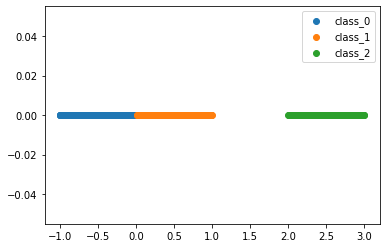

In [120]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [121]:
bg_idx = [ np.where(idx[2] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(175,)

In [122]:
np.unique(bg_idx).shape

(175,)

In [123]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [124]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([-4.82153999e-17]), array([-1.63429327]))

In [125]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [126]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([1.]), array([4.33146331]))

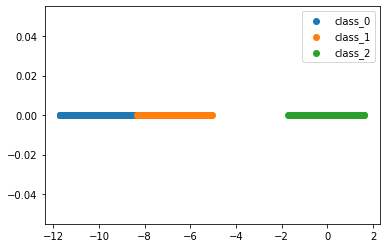

In [127]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [128]:
foreground_classes = {'class_0','class_1' }

background_classes = {'class_2'}

In [129]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
background 2 present at 1
background 2 present at 2
background 2 present at 3
background 2 present at 4
background 2 present at 5
background 2 present at 6
background 2 present at 7
foreground 1 present at 8
(9,)
1 8


In [130]:
a.shape

(9,)

In [131]:
np.reshape(a,(9,1))

array([[-1.15794364],
       [ 0.58697946],
       [-1.69452431],
       [-1.29318477],
       [-0.67262115],
       [ 1.59854334],
       [-0.38598503],
       [-0.67262115],
       [-6.65351041]])

In [132]:
a=np.reshape(a,(3,3))

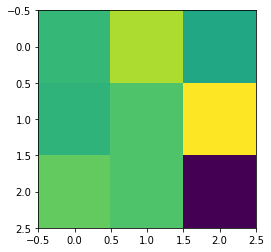

In [133]:
plt.imshow(a)

In [134]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(9,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [135]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [136]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((2000, 9), array([-10.46807047,   1.05650048,   1.27810018,  -0.01725184,
          1.59854334,  -0.88637981,  -0.4593889 ,  -1.53162822,
          1.32266184]))

In [137]:
for j in range(9):
  print(mosaic_list_of_images[0][j])
  

-10.468070470054734
1.0565004769628443
1.278100178112481
-0.017251837431010407
1.598543342240201
-0.8863798117059832
-0.45938889515789527
-1.531628222899254
1.3226618426278711


In [138]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [139]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000] , fore_idx[0:1000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [140]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000] , fore_idx[1000:2000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [141]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.fc1 = nn.Linear(1, 1)
    # self.fc2 = nn.Linear(2, 1)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    # print(x.shape, z.shape)
    for i in range(9):
      # print(z[:,i].shape)
      # print(self.helper(z[:,i])[:,0].shape)
      x[:,i] = self.helper(z[:,i])[:,0]
    # print(x.shape, z.shape)
    x = F.softmax(x,dim=1)
    # print(x.shape, z.shape)
    # x1 = x[:,0]
    # print(torch.mul(x[:,0],z[:,0]).shape)

    for i in range(9):            
      # x1 = x[:,i]          
      y = y + torch.mul(x[:,i],z[:,i])

    # print(x.shape, y.shape)
    return x, y
    
  def helper(self, x):
    x = x.view(-1, 1)
    # x = F.relu(self.fc1(x))
    x = (self.fc1(x))

    return x

In [142]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(1, 1)


  def forward(self, x):
    x = x.view(-1, 1)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [143]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [144]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to("cuda")

In [145]:
focus_net.fc1.weight, focus_net.fc1.bias

(Parameter containing:
 tensor([[-0.0686]], device='cuda:0', dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-0.5345], device='cuda:0', dtype=torch.float64, requires_grad=True))

In [146]:
classify.fc1.weight, classify.fc1.bias

(Parameter containing:
 tensor([[-0.0686]], device='cuda:0', dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-0.5345], device='cuda:0', dtype=torch.float64, requires_grad=True))

In [147]:
focus_net.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[0.0]])))
focus_net.fc1.bias = torch.nn.Parameter(torch.tensor(np.array([0.0])))
focus_net.fc1.weight, focus_net.fc1.bias

(Parameter containing:
 tensor([[0.]], dtype=torch.float64, requires_grad=True), Parameter containing:
 tensor([0.], dtype=torch.float64, requires_grad=True))

In [148]:
classify.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[0.0]])))
classify.fc1.bias = torch.nn.Parameter(torch.tensor(np.array([0.0])))
classify.fc1.weight, classify.fc1.bias

(Parameter containing:
 tensor([[0.]], dtype=torch.float64, requires_grad=True), Parameter containing:
 tensor([0.], dtype=torch.float64, requires_grad=True))

In [149]:
focus_net = focus_net.to("cuda")
classify = classify.to("cuda")

In [150]:
focus_net.fc1.weight, focus_net.fc1.bias

(Parameter containing:
 tensor([[0.]], device='cuda:0', dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.], device='cuda:0', dtype=torch.float64, requires_grad=True))

In [151]:
classify.fc1.weight, classify.fc1.bias

(Parameter containing:
 tensor([[0.]], device='cuda:0', dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.], device='cuda:0', dtype=torch.float64, requires_grad=True))

In [152]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer_classify = optim.SGD(classify.parameters(), lr=0.01, momentum=0.9)
optimizer_focus = optim.SGD(focus_net.parameters(), lr=0.01, momentum=0.9)

# optimizer_classify = optim.Adam(classify.parameters(), lr=0.01)
# optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01)

In [153]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [154]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    # print(outputs.shape)
    predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())
    # print(predicted.shape)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      # print(focus, fore_idx[j], predicted[j])
      if(focus == fore_idx[j] and predicted[j] == labels[j].item()):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j].item()):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j].item()):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j].item()):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += np.sum( np.concatenate(predicted,axis=0)== labels.cpu().numpy() )

print('Accuracy of the network on the 1000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 1000 train images: 49 %
total correct 493
total train set images 1000
focus_true_pred_true 493 =============> FTPT : 49 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 507 =============> FTPF : 50 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000
1000


In [155]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j].item()):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j].item()):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j].item()):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j].item()):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += np.sum( np.concatenate(predicted,axis=0)== labels.cpu().numpy() )

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 1000 test images: 51 %
total correct 519
total train set images 1000
focus_true_pred_true 519 =============> FTPT : 51 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 481 =============> FTPF : 48 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000


In [156]:
nos_epochs = 1000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

every_what_epoch = 1

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
    print(epoch+1,"updating focus_net, classify_net is freezed")
    print("--"*40)
  elif ((epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
    print(epoch+1,"updating classify_net, focus_net is freezed")
    print("--"*40)

  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    labels = labels.float()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())
    # print(predicted.shape)
    # print(outputs.shape,labels.shape)
    # print(outputs)
    # print(labels)
    loss = criterion(outputs[:,0], labels) 
    loss.backward()
    
    if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
      optimizer_focus.step()
    elif ( (epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
      optimizer_classify.step()

    # optimizer_focus.step()
    # optimizer_classify.step()

    running_loss += loss.item()
    mini = 3
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j].item()):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j].item()):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j].item()):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j].item()):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.001):
      break;

  if epoch % 5 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    # print("="*20)
    # print("Train FTPT : ", col4)
    # print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j].item()):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j].item()):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j].item()):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j].item()):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    # print("Test FTPT : ", col10)
    # print("Test FFPT : ", col11)
    # print("="*20)
    
print('Finished Training')

1 updating focus_net, classify_net is freezed
--------------------------------------------------------------------------------
[1,     3] loss: 0.693
2 updating classify_net, focus_net is freezed
--------------------------------------------------------------------------------
[2,     3] loss: 0.693
3 updating focus_net, classify_net is freezed
--------------------------------------------------------------------------------
[3,     3] loss: 0.693
4 updating classify_net, focus_net is freezed
--------------------------------------------------------------------------------
[4,     3] loss: 0.692
5 updating focus_net, classify_net is freezed
--------------------------------------------------------------------------------
[5,     3] loss: 0.692
6 updating classify_net, focus_net is freezed
--------------------------------------------------------------------------------
[6,     3] loss: 0.691
7 updating focus_net, classify_net is freezed
------------------------------------------------------

In [157]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [158]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [159]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [160]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1000,493,0,507,0
1,1,0,1000,493,0,507,0
2,6,0,1000,496,0,504,0
3,11,0,1000,494,0,506,0
4,16,4,996,493,0,507,0
...,...,...,...,...,...,...,...
196,976,596,404,985,0,15,0
197,981,653,347,985,0,15,0
198,986,654,346,988,0,12,0
199,991,642,358,992,0,8,0


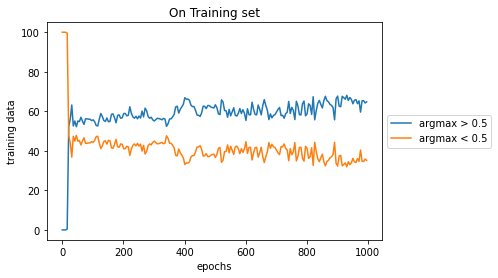

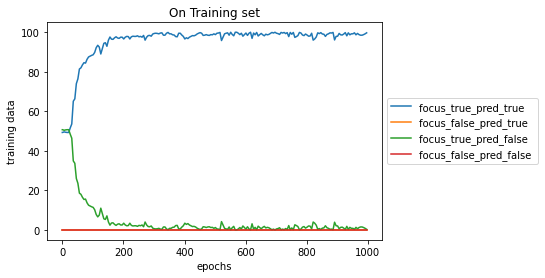

In [161]:
# plt.figure(12,12)
plt.plot(col1,np.array(col2)/10, label='argmax > 0.5')
plt.plot(col1,np.array(col3)/10, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,np.array(col4)/10, label ="focus_true_pred_true ")
plt.plot(col1,np.array(col5)/10, label ="focus_false_pred_true ")
plt.plot(col1,np.array(col6)/10, label ="focus_true_pred_false ")
plt.plot(col1,np.array(col7)/10, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [162]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1000,519,0,481,0
1,1,0,1000,519,0,481,0
2,6,0,1000,531,0,469,0
3,11,0,1000,520,0,480,0
4,16,3,997,519,0,481,0
...,...,...,...,...,...,...,...
196,976,624,376,986,0,14,0
197,981,665,335,998,0,2,0
198,986,672,328,992,0,8,0
199,991,665,335,997,0,3,0


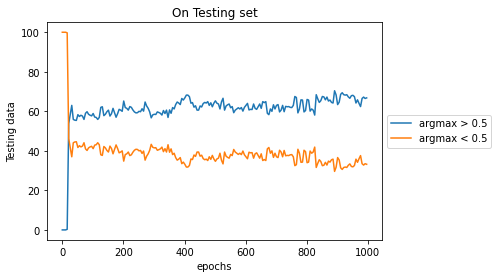

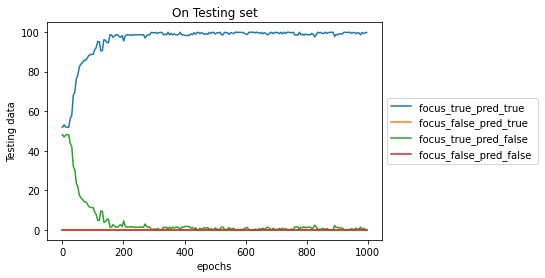

In [163]:
# plt.figure(12,12)
plt.plot(col1,np.array(col8)/10, label='argmax > 0.5')
plt.plot(col1,np.array(col9)/10, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,np.array(col10)/10, label ="focus_true_pred_true ")
plt.plot(col1,np.array(col11)/10, label ="focus_false_pred_true ")
plt.plot(col1,np.array(col12)/10, label ="focus_true_pred_false ")
plt.plot(col1,np.array(col13)/10, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [164]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j].item()):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j].item()):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j].item()):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j].item()):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += np.sum( np.concatenate(predicted,axis=0)== labels.cpu().numpy() )

print('Accuracy of the network on the 1000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 1000 train images: 98 %
total correct 989
total train set images 1000
focus_true_pred_true 989 =============> FTPT : 98 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 11 =============> FTPF : 1 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  654
argmax_less_than_half ==================>  346


In [165]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j].item()):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j].item()):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j].item()):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j].item()):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += np.sum( np.concatenate(predicted,axis=0)== labels.cpu().numpy() )

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 1000 test images: 99 %
total correct 993
total train set images 1000
focus_true_pred_true 993 =============> FTPT : 99 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 7 =============> FTPF : 0 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  672
argmax_less_than_half ==================>  328


In [166]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

    total += labels.size(0)
    correct += np.sum( np.concatenate(predicted,axis=0)== labels.cpu().numpy() )

print('Accuracy of the network on the 1000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 1000 train images: 98 %
total correct 989
total train set images 1000


In [167]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

    total += labels.size(0)
    correct += np.sum( np.concatenate(predicted,axis=0)== labels.cpu().numpy() )

print('Accuracy of the network on the 1000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 1000 test images: 99 %
total correct 993
total train set images 1000


In [168]:
focus_net.fc1.weight, focus_net.fc1.bias

(Parameter containing:
 tensor([[-0.2888]], device='cuda:0', dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-2.7847e-17], device='cuda:0', dtype=torch.float64, requires_grad=True))

In [169]:
classify.fc1.weight, classify.fc1.bias

(Parameter containing:
 tensor([[1.6446]], device='cuda:0', dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([7.9332], device='cuda:0', dtype=torch.float64, requires_grad=True))